## reference: https://www.tensorflow.org/tutorials/structured_data/imbalanced_data

# Classification on imbalanced data

This tutorial demonstrates how to classify a highly imbalanced dataset in which the number of examples in one class greatly outnumbers the examples in another. You will work with the [Credit Card Fraud Detection](https://www.kaggle.com/mlg-ulb/creditcardfraud) dataset hosted on Kaggle. The aim is to detect a mere 492 fraudulent transactions from 284,807 transactions in total. You will use [Keras](https://www.tensorflow.org/guide/keras/overview) to define the model and [class weights](https://www.tensorflow.org/versions/r2.0/api_docs/python/tf/keras/Model) to help the model learn from the imbalanced data. .

This tutorial contains complete code to:

* Load a CSV file using Pandas.
* Create train, validation, and test sets.
* Define and train a model using Keras (including setting class weights).
* Evaluate the model using various metrics (including precision and recall).
* Try common techniques for dealing with imbalanced data like:
    * Class weighting


## Setup

In [2]:
import tensorflow as tf
from tensorflow import keras

import os
import tempfile
import pickle

import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

import sklearn
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

from keras.utils.np_utils import to_categorical
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, Dropout
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.metrics import Recall, Precision

In [3]:
mpl.rcParams['figure.figsize'] = (12, 10)
colors = plt.rcParams['axes.prop_cycle'].by_key()['color']

## Data processing and exploration

### Download the Kaggle Credit Card Fraud data set

Pandas is a Python library with many helpful utilities for loading and working with structured data. It can be used to download CSVs into a Pandas [DataFrame](https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.html#pandas.DataFrame).

Note: This dataset has been collected and analysed during a research collaboration of Worldline and the [Machine Learning Group](http://mlg.ulb.ac.be) of ULB (Université Libre de Bruxelles) on big data mining and fraud detection. More details on current and past projects on related topics are available [here](https://www.researchgate.net/project/Fraud-detection-5) and the page of the [DefeatFraud](https://mlg.ulb.ac.be/wordpress/portfolio_page/defeatfraud-assessment-and-validation-of-deep-feature-engineering-and-learning-solutions-for-fraud-detection/) project

In [5]:
import os, sys
from google.colab import drive
drive.mount('/content/drive')
path='drive/MyDrive/Capstone(Team10)/code'


file = tf.keras.utils
raw_df = pd.read_csv(path+'/data/rawdata_USA.csv', index_col=0, parse_dates=True)
raw_df.index.name='date'
metadata=pd.read_csv(path+'/data/metadata_final.csv')

raw_df.tail(5)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


,BNBUCT02,BNEMTE02,BNODTE02,BNRMTE02,BSCICP02,BSCURT02,BSEMFT02,BSOBLV02,BSOITE02,BSPRTE02,...,BBBOASPREAD,SP500,WTI,W875RX1,VIXCLS,RECPROUSM156N,DXY,y_nber,y_oecd,y_agg
date,,,,,,,,,,,,,,,,,,,,,
2023-02-01,NaN,NaN,NaN,NaN,-2.6,78.4,-1.488108,-10.0,-9.904271,-6.838155,...,1.55,3970.153442,76.83,14622.7,20.12,0.36,104.870003,0,0.0,0.0
2023-03-01,NaN,NaN,NaN,NaN,-3.7,77.8,-4.394159,-10.0,-11.664475,-4.339667,...,1.77,4109.312445,73.28,14664.3,21.64,0.32,102.510002,0,0.0,0.0
2023-04-01,NaN,NaN,NaN,NaN,-2.9,78.4,-0.707885,-11.0,-10.242475,-4.047127,...,1.73,4169.481401,79.45,14659.0,17.82,0.22,101.669998,0,0.0,0.0
2023-05-01,NaN,NaN,NaN,NaN,-3.1,78.4,2.680256,-13.0,-17.834084,1.060291,...,1.80,4179.825462,71.58,14702.7,17.64,0.62,104.320000,0,0.0,0.0
2023-06-01,NaN,NaN,NaN,NaN,-4.0,NaN,-5.300056,-9.0,-6.879287,-6.892674,...,1.69,4450.381312,68.11,NaN,14.00,NaN,102.910004,0,0.0,0.0


In [54]:
len(raw_df.columns)

73

### Examine the class label imbalance

Let's look at the dataset imbalance:

In [55]:
neg, pos = np.bincount(raw_df['y_nber'])
total = neg + pos
print('Examples:\n    Total: {}\n    Positive: {} ({:.2f}% of total)\n'.format(
    total, pos, 100 * pos / total))

Examples:
    Total: 1074
    Positive: 145 (13.50% of total)



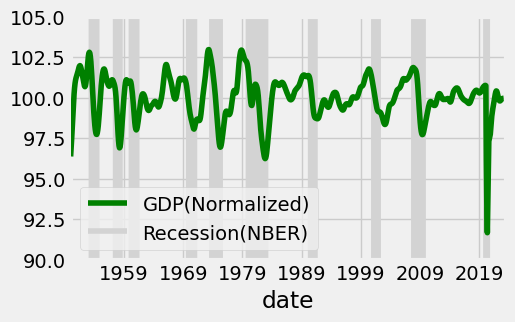

In [56]:
data=raw_df.loc[raw_df.index.year>=1950]

fig, ax=plt.subplots(figsize=(5,3))

lines=data['LORSGPNO'].plot(ax=ax, color=['green'], zorder=200)
area=(data['y_nber']*1000).plot.area(ax=ax, color='#d3d3d3')
ax.set_ylim([90,105])
ax.legend(['GDP(Normalized)','Recession(NBER)'])

In [57]:
neg, pos = np.bincount(raw_df['y_oecd'].dropna())
total = neg + pos
print('Examples:\n    Total: {}\n    Positive: {} ({:.2f}% of total)\n'.format(
    total, pos, 100 * pos / total))

Examples:
    Total: 885
    Positive: 382 (43.16% of total)



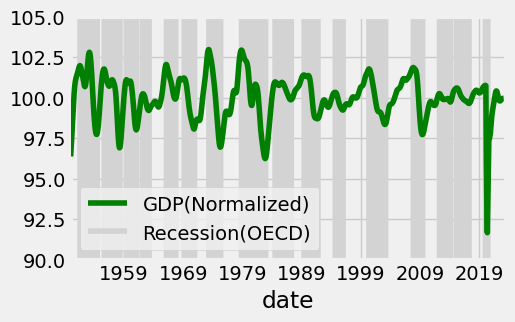

In [58]:
data=raw_df.loc[raw_df.index.year>=1950]

fig, ax=plt.subplots(figsize=(5,3))

lines=data['LORSGPNO'].plot(ax=ax, color=['green'], zorder=200)
area=(data['y_oecd']*1000).plot.area(ax=ax, color='#d3d3d3')
ax.set_ylim([90,105])
ax.legend(['GDP(Normalized)','Recession(OECD)'])

In [59]:
neg, pos1, pos2 = np.bincount(raw_df['y_agg'].dropna())
total = neg + pos1 + pos2
print('Examples:\n    Total: {}\n\
    Positive1: {} ({:.2f}% of total)\n\
    Positive2: {} ({:.2f}% of total)\n'.format(
    total, pos1, 100 * pos1 / total, pos2, 100 * pos2 / total))

Examples:
    Total: 885
    Positive1: 270 (30.51% of total)
    Positive2: 113 (12.77% of total)



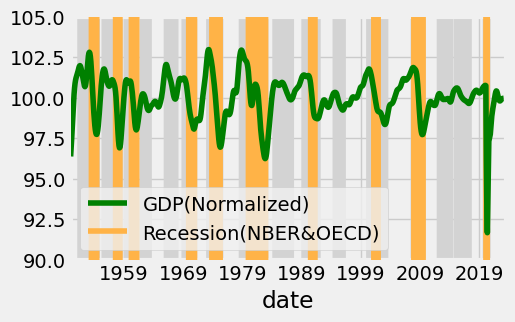

In [60]:
data=raw_df.loc[raw_df.index.year>=1950]

fig, ax=plt.subplots(figsize=(5,3))

lines=data['LORSGPNO'].plot(ax=ax, color=['green'], zorder=200)
area1=(data['y_nber']*1000).plot.area(ax=ax, color='#ffb347', zorder=3)
area2=(data['y_oecd']*1000).plot.area(ax=ax, color='#d3d3d3')

ax.set_ylim([90,105])
ax.legend(['GDP(Normalized)','Recession(NBER&OECD)'])

This shows the small fraction of positive samples.

### Split Dataset into Train, Validation, Test data

We will use last 5 years for final test set. And for cross validation, we will use 5 blocked time-series split.

In [61]:
## specifying variable names for X and y
y_list=list(metadata[metadata.Level=='Recession']['SUBJECT'])
x_list=[x for x in raw_df.columns if x not in y_list]
len(y_list), len(x_list)

## split raw_df into X and y
X=raw_df[x_list]
y=raw_df['y_nber']  # options: y_nber, y_oecd, or y_agg

In [62]:
#metadata.SUBJECT[-20:]  ##BBBYIELD, BBBOASPREAD
(len(X)-X[['BBBYIELD', 'BBBOASPREAD']].isna().sum())/12

BBBYIELD       26.5
BBBOASPREAD    26.5
dtype: float64

In [63]:
## extract features with more than 50 years and store the features in selected features
#threshold=55

year_dict=dict(round((len(X)-X.isna().sum())/12,2))

# selected_features=[metadata[metadata.SUBJECT==x]['SUBJECT'].values[0] for x in year_dict.keys() if year_dict[x]>=threshold]
# [metadata[metadata.SUBJECT==x]['Name'].values[0] for x in year_dict.keys() if year_dict[x]>=threshold]

feature_dict={}
thresholds=[30,35,40,45,50,55]

for threshold in thresholds:
  selected_features=[metadata[metadata.SUBJECT==x]['SUBJECT'].values[0] for x in year_dict.keys() if year_dict[x]>=threshold]
  feature_dict[threshold]=selected_features
  print (threshold, 'narrow down to', len(selected_features), 'features.')

30 narrow down to 54 features.
35 narrow down to 51 features.
40 narrow down to 50 features.
45 narrow down to 49 features.
50 narrow down to 46 features.
55 narrow down to 45 features.


In [64]:
for threshold in [30,35,40,45,50]:
  drop_features=[metadata[metadata.SUBJECT==x]['Name'].values[0] for x in feature_dict[threshold] if x not in feature_dict[threshold+5]]
  print('threshold {} to {}: dropped features are '.format(threshold, threshold+5), drop_features)

threshold 30 to 35: dropped features are  ['Business tendency surveys (manufacturing) Order books Level National indicator', 'Business tendency surveys (manufacturing) Export order books or demand Level National indicator', 'CBOE Volatility Index: VIX']
threshold 35 to 40: dropped features are  ['Dollar Index, Monthly end']
threshold 40 to 45: dropped features are  ['Consumer Price Index OECD Groups Housing Total']
threshold 45 to 50: dropped features are  ['Consumer opinion surveys Economic Situation Future tendency National indicator', 'Consumer opinion surveys Consumer prices (inflation) Future tendency National indicator', 'Labour Force Survey - quarterly levels Inactive population Aged 15 and over All persons']
threshold 50 to 55: dropped features are  ['Currency Conversions Real effective exchange rates Overall Economy CPI']


In [65]:
## let's try threshold of 50
threshold=50
selected_features=feature_dict[threshold]
missing_dict=dict(X[selected_features][-(threshold*12+6):].isna().sum())
missing_varlist=[x for x in missing_dict if (missing_dict[x]>0)&(missing_dict[x]<10)]

##'IR3TED01': 24 missing values (discontinued)--> drop
## other variables: only 1~2 missing values --> missing recent values --> cut to available periods(~22.12)
## 'PIEAEN01','PIEAMP01': 6 missing values --> missing recent values --> cut to available periods(~22.12)
## 'IR3TCD01','IR3TIB01': missing values in the midst of the series --> using interpolation

#X[selected_features][-(threshold*12+6):].head(10)
#metadata[metadata.SUBJECT=='IR3TED01']['Name']
# plt.plot(X[['PIEAEN01','PIEAMP01']])
# plt.plot(X['IR3TED01'])

In [66]:
## reduce the X data for periods 1973.1~2022.11
selected_features=[x for x in selected_features if x!='IR3TED01']


In [67]:
## it turns out that two data series have same values --> so only use 'IR3TCD01'(&drop 'IR3TIB01')
#metadata[metadata.SUBJECT.isin(['IR3TCD01','IR3TIB01'])]['Name'].values
#(X_data['IR3TCD01']==X_data['IR3TIB01']).value_counts()
selected_features=[x for x in selected_features if x!='IR3TIB01']

X_data=X[selected_features][-(threshold*12+6):-6]
y_data=y[-(threshold*12+6):-6]
X_data['IR3TCD01']=X_data['IR3TCD01'].interpolate(method='linear')
X_data.isna().sum()

BSCICP02     0
BSCURT02     0
BSEMFT02     0
BSOITE02     0
BSPRTE02     0
CCRETT01     0
CPALTT01     0
CPGREN01     0
CPGRLE01     0
CSCICP02     0
HOHWMN02     0
IR3TCD01     0
IRLTLT01     0
IRSTFR01     0
LCEAMN01     0
LCEAPR01     0
LFACTTTT     0
LFEMTTTT     0
LFHUTTTT     0
LFUNTTTT     0
LREMTTTT     0
LRHU24TT     0
LRUNTTTT     0
MABMM301     0
MANMM101     0
ODMNTO02     0
PIEAEN01     0
PIEAMP01     0
PRCNTO01     0
PRINTO01     0
PRMNTO01     0
SLMNTO02     0
SLRTTO02     0
SLWHTO02     0
STMNIS01     0
WSCNDW01     0
XTEXVA01     0
XTIMVA01     0
3MTBILL      0
10YT         0
103SPREAD    0
SP500        0
WTI          0
W875RX1      0
dtype: int64

In [68]:
## reference : https://gmnam.tistory.com/230#:~:text=class%20BlockingTimeSeriesSplit%28%29%3A%20def%20__init__%28self%2C%20n_splits%29%3A%20self.n_splits%20%3D%20n_splits,indices%20%5Bstart%3A%20mid%5D%2C%20indices%20%5Bmid%20%2B%20margin%3A%20stop%5D


from sklearn.model_selection import TimeSeriesSplit
from matplotlib.patches import Patch
import matplotlib.pyplot as plt

cmap_data = plt.cm.Paired
cmap_cv = plt.cm.coolwarm
plt.style.use('fivethirtyeight')

class BlockingTimeSeriesSplit():
    def __init__(self, n_splits):
        self.n_splits = n_splits

    def get_n_splits(self, groups):
        return self.n_splits

    def split(self, X, y=None, groups=None):
        n_samples = len(X)
        k_fold_size = n_samples // self.n_splits
        indices = np.arange(n_samples)

        margin = 0
        for i in range(self.n_splits):
            start = i * k_fold_size
            stop = start + k_fold_size
            mid = int(0.8 * (stop - start)) + start
            yield indices[start: mid], indices[mid + margin: stop]

def plot_cv_indices(cv, X, n_splits, lw=10):

    fig, ax = plt.subplots()
    """Create a sample plot for indices of a cross-validation object."""

    # Generate the training/testing visualizations for each CV split
    for ii, (tr, tt) in enumerate(cv.split(X=X)):
        # Fill in indices with the training/test groups
        indices = np.array([np.nan] * len(X))
        indices[tt] = 1
        indices[tr] = 0

        # Visualize the results
        ax.scatter(range(len(indices)), [ii + .5] * len(indices),
                   c=indices, marker='_', lw=lw, cmap=cmap_cv,
                   vmin=-.2, vmax=1.2)

    # Formatting
    yticklabels = list(range(n_splits))
    ax.set(yticks=np.arange(n_splits) + .5, yticklabels=yticklabels,
           xlabel='Sample index', ylabel="CV iteration",
           ylim=[n_splits+0.1, -.1], xlim=[0, len(X)])
    ax.set_title('{}'.format(type(cv).__name__), fontsize=15)

    ax.legend([Patch(color=cmap_cv(.8)), Patch(color=cmap_cv(.02))],
          ['Testing set', 'Training set'], loc=(1.02, .8))

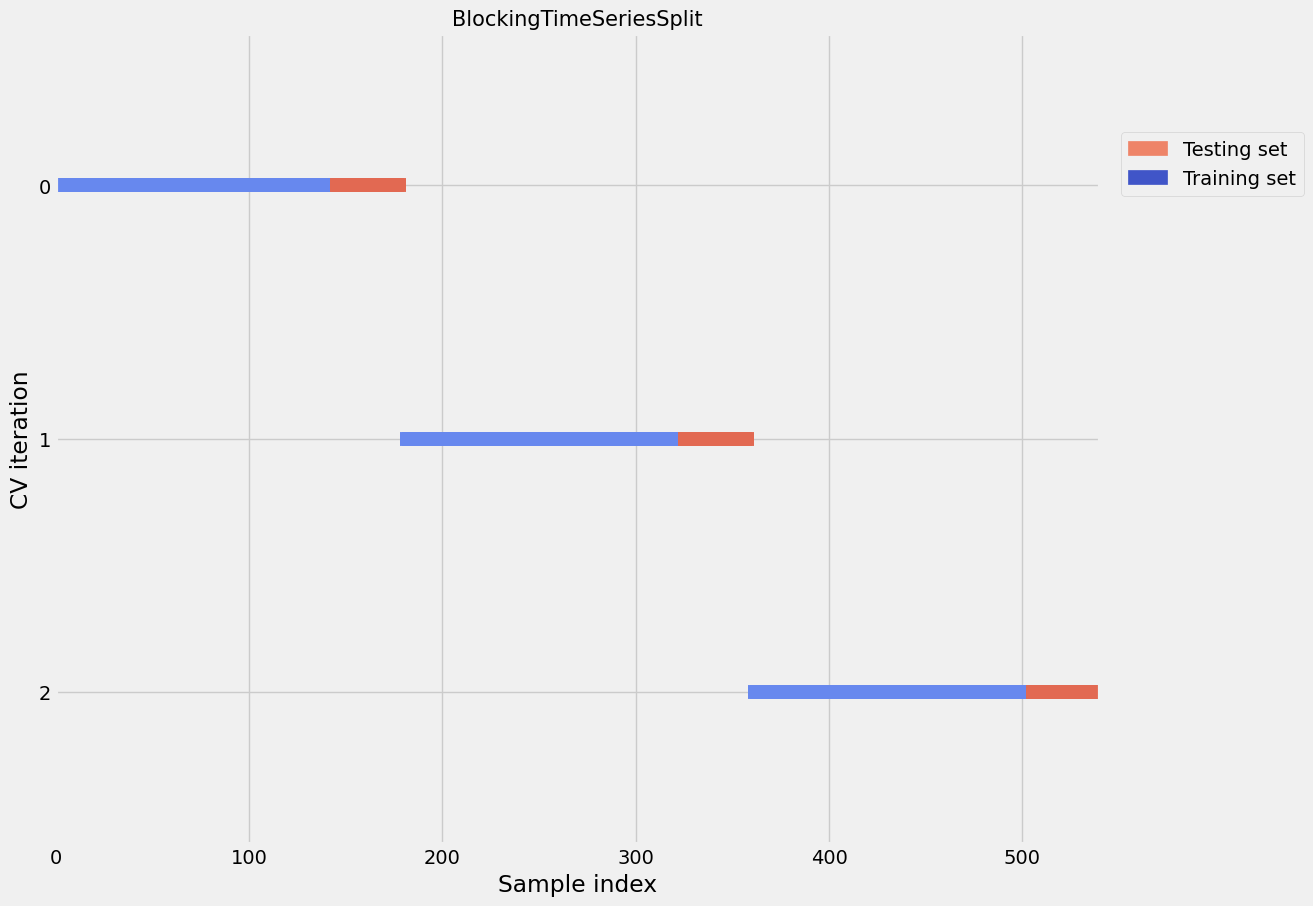

In [69]:
test_year=5
n_splits=3

tss=BlockingTimeSeriesSplit(n_splits=n_splits)
plot_cv_indices(tss, X_data[:-(test_year*12)], n_splits=n_splits)

In [70]:
## make index for train, validation dataset
train_idxs=[]
val_idxs=[]

for train_idx, val_idx in tss.split(X_data[:-(test_year*12)]):
  train_idxs.append(train_idx)
  val_idxs.append(val_idx)

# train_idxs[2], val_idxs[2]  ## train and test dataset in 5th block

In [71]:
## checking if validation dataset in each block contains at least one recession period.

for i, idx in enumerate(train_idxs):
  n_pos=raw_df['y_nber'][idx].value_counts()[1]
  print('positive class in {} validation:'.format(i), n_pos)

positive class in 0 validation: 21
positive class in 1 validation: 36
positive class in 2 validation: 27


Split the dataset into train, validation, and test sets. The validation set is used during the model fitting to evaluate the loss and any metrics, however the model is not fit with this data. The test set is completely unused during the training phase and is only used at the end to evaluate how well the model generalizes to new data. This is especially important with imbalanced datasets where [overfitting](https://developers.google.com/machine-learning/crash-course/generalization/peril-of-overfitting) is a significant concern from the lack of training data.

In [72]:
# # Try the first block

# X_train=X_data.iloc[list(train_idxs[0])]
# y_train=y_data.iloc[list(train_idxs[0])]
# X_val=X_data.iloc[list(val_idxs[0])]
# y_val=y_data.iloc[list(val_idxs[0])]
# X_test=X_data.iloc[-test_year*12:]
# y_test=y_data.iloc[-test_year*12:]

# train_features = np.array(X_train)
# val_features = np.array(X_val)
# test_features = np.array(X_test)

# train_labels = np.array(y_train)
# val_labels = np.array(y_val)
# test_labels = np.array(y_test)

In [73]:
# for train_idx, val_idx in zip(train_idxs, val_idxs):
#   print(train_idx, val_idx)

Normalize the input features using the sklearn StandardScaler.
This will set the mean to 0 and standard deviation to 1.

Note: The `StandardScaler` is only fit using the `train_features` to be sure the model is not peeking at the validation or test sets.

In [74]:
# scaler = StandardScaler()
# train_features = scaler.fit_transform(train_features)

# val_features = scaler.transform(val_features)
# test_features = scaler.transform(test_features)

# print('Training labels shape:', train_labels.shape)
# print('Validation labels shape:', val_labels.shape)
# print('Test labels shape:', test_labels.shape)

# print('Training features shape:', train_features.shape)
# print('Validation features shape:', val_features.shape)
# print('Test features shape:', test_features.shape)

In [75]:
# trainx, trainy = create_dataset(X_train, y_train, time_steps=12)
# valx, valy = create_dataset(X_val, y_val, time_steps=12)
# trainy=to_categorical(trainy, num_classes=2)
# valy=to_categorical(valy, num_classes=2)
# print(trainx.shape, trainy.shape, valx.shape, valy.shape)

In [76]:
#trainx[:5]

## Create temporal feature dataset for recession.

In [77]:

# def get_data(X, y, y_type, test_year, features):
#     X_train=X[features][:-(test_year*12)]
#     y_train=y[y_type][:-(test_year*12)]
#     X_test=X[features][-(test_year*12):]
#     y_test=y[y_type][-(test_year*12):]

#     return X_train, y_train, X_test, y_test

## time_step means the length(n) of explanatory variables(t-(n-1) ~ t) to use for classifying y in certain time(t) period.
def create_dataset(X, y, time_steps=1):
    Xs, ys = [], []

    if type(Xs)==pd.core.frame.DataFrame:
      for i in range(len(X) - time_steps):
          v = X.iloc[i:(i + time_steps)].values
          Xs.append(v)
          ys.append(y.iloc[i + time_steps].values)
          Xs=np.array(Xs)
          ys=np.array(ys)

    else:
      for i in range(len(X) - time_steps):
          v = X[i:(i + time_steps)]
          Xs.append(v)
          ys.append(y[i + time_steps])

    return np.array(Xs), np.array(ys)

In [78]:
## make index for train, validation dataset
def make_split(X_data, n_splits, test_year):
  train_idxs=[]
  val_idxs=[]

  tss=BlockingTimeSeriesSplit(n_splits=n_splits)

  for train_idx, val_idx in tss.split(X_data[:-(test_year*12)]):
    train_idxs.append(train_idx)
    val_idxs.append(val_idx)

  return train_idxs, val_idxs



In [79]:
def make_model(num_layer, X_train, nc, metrics, loss_type):
    model = Sequential()
    model.add(LSTM(num_layer, input_shape=(X_train.shape[1], X_train.shape[2])))  ##input_shape=(X_train.shape[1], X_train.shape[2])
    # model.add(Dropout(0.2))
    #model.add(Dense(2))
    model.add(Dense(nc, activation='sigmoid'))
    model.compile(loss=loss_type, optimizer='adam', metrics=metrics)  ##['AUC','Accuracy','Recall','Precision','F1Score']
    return model


In [80]:
# metrics=['AUC','Accuracy','Recall','Precision']
# loss_type='binary_crossentropy'
# nc=2
# num_layer=10

# model=make_model(num_layer, trainx, nc, metrics, loss_type)
# type(model)

# history=model.fit(trainx, trainy, epochs=10, batch_size=5)
# scores = model.evaluate(valx, valy, verbose=0)

In [81]:
# train_idx=train_idxs[0]
# val_idx=val_idxs[0]
# time_step=18

# X_train=X_data.iloc[list(train_idx)]
# y_train=y_data.iloc[list(train_idx)]
# X_val=X_data.iloc[list(val_idx)]
# y_val=y_data.iloc[list(val_idx)]


# testx = np.array(X_data.iloc[-test_year*12:])
# testy = np.array(y_data.iloc[-test_year*12:])

# ##standard scaling
# scaler = StandardScaler()
# trainx = scaler.fit_transform(X_train)
# valx = scaler.transform(X_val)
# testx = scaler.transform(testx)

# ##make timestep
# trainx, trainy = create_dataset(X_train, y_train, time_step)
# valx, valy = create_dataset(X_val, y_val, time_step)
# testx, testy = create_dataset(testx, testy, time_step)
# trainy = to_categorical(y_train, num_classes=nc)
# valy = to_categorical(y_val, num_classes=nc)
# testy = to_categorical(testy, num_classes=nc)

In [84]:
def grid_search(path, X_data, y_data, y_type, n_splits, test_year, metrics=['AUC','Accuracy','Recall','Precision'],
                nl=[10, 30, 50, 100], epochs=[30,50,70,100], batch_sizes=[6], time_steps=[18,24]):
  results = []
  history_dict={}
  best_auc = 0
  best_params = None
  nc=len(y_data.unique())

  train_idxs, val_idxs = make_split(X_data, n_splits, test_year)

  for time_step in time_steps:
    loss_type = 'categorical_crossentropy'   ##if y_type == 'y_agg' else 'binary_crossentropy'
    for num_epochs in epochs:
      for batch_size in batch_sizes:
        for num_layer in nl:

          auc=0
          acc=0
          recall=0
          precision=0

          for train_idx, val_idx in zip(train_idxs, val_idxs):

            X_train=X_data.iloc[list(train_idx)]
            y_train=y_data.iloc[list(train_idx)]
            X_val=X_data.iloc[list(val_idx)]
            y_val=y_data.iloc[list(val_idx)]


            X_test=X_data.iloc[-test_year*12:]
            y_test=y_data.iloc[-test_year*12:]

            ##standard scaling
            scaler = StandardScaler()
            X_train = scaler.fit_transform(X_train)
            X_val = scaler.transform(X_val)
            X_test = scaler.transform(X_test)

            # print(X_train)
            # print(X_val)
            # print(X_test)

            ##make timestep
            trainx, trainy = create_dataset(X_train, y_train, time_step) ##(X_train, y_train, time_step)
            valx, valy = create_dataset(X_val, y_val, time_step)   ##(X_val, y_val, time_step)
            testx, testy = create_dataset(X_test, y_test, time_step) ##(X_test, y_test, time_step)
            trainy = to_categorical(trainy, num_classes=nc)
            valy = to_categorical(valy, num_classes=nc)
            testy = to_categorical(testy, num_classes=nc)

            ##assign class weight(more weight for less frequent class)
            neg, pos = np.bincount(y_train)
            total = neg + pos

            weight_for_0 = (1 / neg) * (total / 2.0)
            weight_for_1 = (1 / pos) * (total / 2.0)

            class_weight = {0: weight_for_0, 1: weight_for_1}


            # create the model weighted more for class 1
            model=make_model(num_layer, trainx, nc, metrics, loss_type)
            history=model.fit(trainx, trainy, epochs=num_epochs, batch_size=batch_size, class_weight=class_weight)
#                  print(model.summary())

            # Final evaluation of the model
            scores = model.evaluate(valx, valy, verbose=0)
            #print(scores)
            auc += scores[1]
            acc += scores[2]
            recall += scores[3]
            precision += scores[4]
            #print("AUC: %.2f%%" % (auc))

          auc=auc/n_splits
          acc=acc/n_splits
          recall=recall/n_splits
          precision=precision/n_splits

          final_scores=model.evaluate(testx, testy, verbose=0)  ##test...?
          final_auc=final_scores[1]
          final_acc=final_scores[2]
          final_recall=final_scores[3]
          final_precision=final_scores[4]

          model_name='clf_lstm_{}_{}_b{}_ep{}_h{}'.format(y_type, time_step, batch_size, num_epochs, num_layer)
          model.save(path+'/model/{}.h5'.format(model_name))
          current_result = {'model':model_name,
                            'auc': auc,
                            'accuracy': acc,
                            'recall': recall,
                            'precision': precision,  #"%.2f%%" % (precision)
                            'final_auc':final_auc,
                            'final_acc':final_acc,
                            'final_recall':final_recall,
                            'final_precision':final_precision,
                            }
          results.append(current_result)

          if auc > best_auc:
            best_model = model_name
            best_auc = auc
            best_params = current_result

  print("Best model: ", best_model)
  return results


In [92]:
######################run this cell only for training whole models####################################

y_type='y_nber'
n_splits=3
test_year=5

results=grid_search(path, X_data, y_data, y_type, n_splits, test_year)

with open(path+'/model/results.pkl', 'wb') as f:
  pickle.dump(results, f)

with open(path+'/model/results.pkl','rb') as f:
  results=pickle.load(f)

# results=grid_search(path, X_data, y_data, y_type, n_splits, test_year,
#                     nl=[10], epochs=[30], batch_sizes=[6], time_steps=[12])


스트리밍 출력 내용이 길어서 마지막 5000줄이 삭제되었습니다.
20/20 [==============================] - 0s 8ms/step - loss: 0.0199 - auc: 1.0000 - Accuracy: 1.0000 - recall: 1.0000 - precision: 1.0000
Epoch 42/50
20/20 [==============================] - 0s 8ms/step - loss: 0.0355 - auc: 0.9998 - Accuracy: 0.9917 - recall: 0.9917 - precision: 0.9917
Epoch 43/50
20/20 [==============================] - 0s 7ms/step - loss: 0.0393 - auc: 0.9898 - Accuracy: 0.9750 - recall: 0.9750 - precision: 0.9750
Epoch 44/50
20/20 [==============================] - 0s 8ms/step - loss: 0.0266 - auc: 0.9990 - Accuracy: 0.9833 - recall: 0.9833 - precision: 0.9833
Epoch 45/50
20/20 [==============================] - 0s 8ms/step - loss: 0.0170 - auc: 0.9999 - Accuracy: 0.9917 - recall: 1.0000 - precision: 0.9917
Epoch 46/50
20/20 [==============================] - 0s 7ms/step - loss: 0.0196 - auc: 1.0000 - Accuracy: 1.0000 - recall: 1.0000 - precision: 1.0000
Epoch 47/50
20/20 [==============================] - 0s 8ms/step - loss: 0.0

In [6]:
with open(path+'/model/results.pkl','rb') as f:
  results=pickle.load(f)

df_result=pd.DataFrame(results)

## model selection: according to cross validation recall, auc scores
df_result.sort_values(['recall','auc'], ascending=[False, False]).iloc[0]

model              clf_lstm_y_nber_24_b6_ep30_h10
auc                                           1.0
accuracy                                      1.0
recall                                        1.0
precision                                     1.0
final_auc                                0.946373
final_acc                                0.944444
final_recall                             0.944444
final_precision                          0.944444
Name: 16, dtype: object

In [ ]:
with open(path+'/data/X_data.pkl', 'wb') as f:
  pickle.dump(X_data, f)

with open(path+'/data/y_data.pkl', 'wb') as f:
  pickle.dump(y_data, f)

with open(path+'/data/selected_features.pkl', 'wb') as f:
  pickle.dump(selected_features, f)

## SHAP analysis

In [ ]:
import tensorflow as tf
tf.compat.v1.disable_v2_behavior()  ## input type err solved
from tensorflow.keras.models import load_model
from keras.utils.np_utils import to_categorical
import shap
import pickle

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix,classification_report

In [ ]:
## manually assign value
model_name='clf_lstm_y_oecd_24_b5_ep300_h100'

y_type = model_name.split('_')[2]+'_'+model_name.split('_')[3]
test_year=5
time_step=int(model_name.split('_')[4])
batch_size=int(model_name.split('_')[5][1:])
num_epochs=int(model_name.split('_')[6][2:])
num_layer=int(model_name.split('_')[7][1:])
metrics=['AUC','Accuracy','Recall','Precision']

if y_type=='y_agg':
    num_classes=3
else:
    num_classes=2

print(y_type, ' time step:', time_step, ' batch size:', batch_size, ' #epoch:', num_epochs, ' #class:', num_classes, ' num_layer:', num_layer)

In [ ]:
## whole train dataset
X_train=X_data.iloc[:-test_year*12]
y_train=y_data.iloc[:-test_year*12]
X_test=X_data.iloc[-test_year*12:]
y_test=y_data.iloc[-test_year*12:]

## standard scaling
scaler = StandardScaler()
trainx = scaler.fit_transform(X_train)
testx = scaler.transform(X_test)

## make timestep
trainx, trainy = create_dataset(X_train, y_train, time_step)
testx, testy = create_dataset(X_test, y_test, time_step)
trainy = to_categorical(trainy, num_classes=nc)
testy = to_categorical(testy, num_classes=nc)

## calculate class weight
neg, pos = np.bincount(y_train)
total = neg + pos

weight_for_0 = (1 / neg) * (total / 2.0)
weight_for_1 = (1 / pos) * (total / 2.0)

class_weight = {0: weight_for_0, 1: weight_for_1}

# create the model weighting more for class 1 & train the model
final_model=make_model(num_layer, trainx, num_classes, metrics, 'categorical_crossentropy')
history=final_model.fit(trainx, trainy, epochs=num_epochs, batch_size=batch_size, class_weight=class_weight)

## generate shap explainer and calculate shap values
explainer=shap.DeepExplainer(final_model, trainx)
values_test=explainer.shap_values(np.array(testx))
values_train=explainer.shap_values(np.array(trainx))

## Define the model and metrics

Define a function that creates a simple neural network with a densly connected hidden layer, a [dropout](https://developers.google.com/machine-learning/glossary/#dropout_regularization) layer to reduce overfitting, and an output sigmoid layer that returns the probability of a transaction being fraudulent:

In [ ]:
METRICS = [
      keras.metrics.TruePositives(name='tp'),
      keras.metrics.FalsePositives(name='fp'),
      keras.metrics.TrueNegatives(name='tn'),
      keras.metrics.FalseNegatives(name='fn'),
      keras.metrics.BinaryAccuracy(name='accuracy'),
      keras.metrics.Precision(name='precision'),
      keras.metrics.Recall(name='recall'),
      keras.metrics.AUC(name='auc'),
      keras.metrics.AUC(name='prc', curve='PR'), # precision-recall curve
]

def make_model(metrics=METRICS, output_bias=None):
  if output_bias is not None:
    output_bias = tf.keras.initializers.Constant(output_bias)
  model = keras.Sequential([
      keras.layers.LSTM(
          16, activation='relu',
          input_shape=(train_features.shape[-1],)),
      keras.layers.Dropout(0.5),
      keras.layers.Dense(1, activation='sigmoid',
                         bias_initializer=output_bias),
  ])

  model.compile(
      optimizer=keras.optimizers.Adam(learning_rate=1e-3),
      loss=keras.losses.BinaryCrossentropy(),
      metrics=metrics)

  return model

### Understanding useful metrics

Notice that there are a few metrics defined above that can be computed by the model that will be helpful when evaluating the performance.



*   **False** negatives and **false** positives are samples that were **incorrectly** classified
*   **True** negatives and **true** positives are samples that were **correctly** classified
*   **Accuracy** is the percentage of examples correctly classified
>   $\frac{\text{true samples}}{\text{total samples}}$
*   **Precision** is the percentage of **predicted** positives that were correctly classified
>   $\frac{\text{true positives}}{\text{true positives + false positives}}$
*   **Recall** is the percentage of **actual** positives that were correctly classified
>   $\frac{\text{true positives}}{\text{true positives + false negatives}}$
*   **AUC** refers to the Area Under the Curve of a Receiver Operating Characteristic curve (ROC-AUC). This metric is equal to the probability that a classifier will rank a random positive sample higher than a random negative sample.
*   **AUPRC** refers to Area Under the Curve of the Precision-Recall Curve. This metric computes precision-recall pairs for different probability thresholds.

Note: Accuracy is not a helpful metric for this task. You can have 99.8%+ accuracy on this task by predicting False all the time.  

Read more:
*  [True vs. False and Positive vs. Negative](https://developers.google.com/machine-learning/crash-course/classification/true-false-positive-negative)
*  [Accuracy](https://developers.google.com/machine-learning/crash-course/classification/accuracy)
*   [Precision and Recall](https://developers.google.com/machine-learning/crash-course/classification/precision-and-recall)
*   [ROC-AUC](https://developers.google.com/machine-learning/crash-course/classification/roc-and-auc)
*   [Relationship between Precision-Recall and ROC Curves](https://www.biostat.wisc.edu/~page/rocpr.pdf)

## Build Model with weighting cost for class

In [ ]:
# Scaling by total/2 helps keep the loss to a similar magnitude.
# The sum of the weights of all examples stays the same.
neg, pos = np.bincount(raw_df['y_nber'])
total = neg + pos

weight_for_0 = (1 / neg) * (total / 2.0)
weight_for_1 = (1 / pos) * (total / 2.0)

class_weight = {0: weight_for_0, 1: weight_for_1}

print('Weight for class 0: {:.2f}'.format(weight_for_0))
print('Weight for class 1: {:.2f}'.format(weight_for_1))

## train weighted model
weighted_model = make_model()
##weighted_model.load_weights(initial_weights)

weighted_history = weighted_model.fit(
    train_features,
    train_labels,
    batch_size=BATCH_SIZE,
    epochs=EPOCHS,
    callbacks=[early_stopping],
    validation_data=(val_features, val_labels),
    # The class weights go here
    class_weight=class_weight)


In [ ]:
# Scaling by total/2 helps keep the loss to a similar magnitude.
# The sum of the weights of all examples stays the same.
neg, pos = np.bincount(trainy)
total = neg + pos

weight_for_0 = (1 / neg) * (total / 2.0)
weight_for_1 = (1 / pos) * (total / 2.0)

class_weight = {0: weight_for_0, 1: weight_for_1}

print('Weight for class 0: {:.2f}'.format(weight_for_0))
print('Weight for class 1: {:.2f}'.format(weight_for_1))

## train weighted model
weighted_model = make_model()
##weighted_model.load_weights(initial_weights)

weighted_history = weighted_model.fit(
    train_features,
    train_labels,
    batch_size=BATCH_SIZE,
    epochs=EPOCHS,
    callbacks=[early_stopping],
    validation_data=(val_features, val_labels),
    # The class weights go here
    class_weight=class_weight)


In [ ]:
def plot_metrics(history):
  metrics = ['loss', 'prc', 'precision', 'recall']
  for n, metric in enumerate(metrics):
    name = metric.replace("_"," ").capitalize()
    plt.subplot(2,2,n+1)
    plt.plot(history.epoch, history.history[metric], color=colors[0], label='Train')
    plt.plot(history.epoch, history.history['val_'+metric],
             color=colors[0], linestyle="--", label='Val')
    plt.xlabel('Epoch')
    plt.ylabel(name)
    if metric == 'loss':
      plt.ylim([0, plt.ylim()[1]])
    elif metric == 'auc':
      plt.ylim([0.8,1])
    else:
      plt.ylim([0,1])

    plt.legend()

In [ ]:
plot_metrics(weighted_history)

In [ ]:
train_predictions_baseline = model.predict(train_features, batch_size=BATCH_SIZE)
test_predictions_baseline = model.predict(test_features, batch_size=BATCH_SIZE)

In [ ]:
def plot_cm(labels, predictions, p=0.5):
  cm = confusion_matrix(labels, predictions > p)
  plt.figure(figsize=(5,5))
  sns.heatmap(cm, annot=True, fmt="d")
  plt.title('Confusion matrix @{:.2f}'.format(p))
  plt.ylabel('Actual label')
  plt.xlabel('Predicted label')

  print('Legitimate Transactions Detected (True Negatives): ', cm[0][0])
  print('Legitimate Transactions Incorrectly Detected (False Positives): ', cm[0][1])
  print('Fraudulent Transactions Missed (False Negatives): ', cm[1][0])
  print('Fraudulent Transactions Detected (True Positives): ', cm[1][1])
  print('Total Fraudulent Transactions: ', np.sum(cm[1]))

In [ ]:
results = model.evaluate(test_features, test_labels,
                                  batch_size=BATCH_SIZE, verbose=0)
for name, value in zip(model.metrics_names, results):
  print(name, ': ', value)
print()

plot_cm(test_labels, test_predictions_baseline)

In [ ]:
def plot_roc(name, labels, predictions, **kwargs):
  fp, tp, _ = sklearn.metrics.roc_curve(labels, predictions)

  plt.plot(100*fp, 100*tp, label=name, linewidth=2, **kwargs)
  plt.xlabel('False positives [%]')
  plt.ylabel('True positives [%]')
  plt.xlim([-0.5,20])
  plt.ylim([80,100.5])
  plt.grid(True)
  ax = plt.gca()
  ax.set_aspect('equal')

In [ ]:
plot_roc("Train Baseline", train_labels, train_predictions_baseline, color=colors[0])
plot_roc("Test Baseline", test_labels, test_predictions_baseline, color=colors[0], linestyle='--')
plt.legend(loc='lower right');

In [ ]:
def plot_prc(name, labels, predictions, **kwargs):
    precision, recall, _ = sklearn.metrics.precision_recall_curve(labels, predictions)

    plt.plot(precision, recall, label=name, linewidth=2, **kwargs)
    plt.xlabel('Precision')
    plt.ylabel('Recall')
    plt.grid(True)
    ax = plt.gca()
    ax.set_aspect('equal')

In [ ]:
plot_prc("Train Baseline", train_labels, train_predictions_baseline, color=colors[0])
plot_prc("Test Baseline", test_labels, test_predictions_baseline, color=colors[0], linestyle='--')
plt.legend(loc='lower right');